[[  8.          10.          13.59104223   2.        ]
 [ 11.          17.          15.21426845   2.        ]
 [  1.          19.          20.19378299   3.        ]
 [  0.          13.          24.05979809   2.        ]
 [  6.          12.          24.16991762   2.        ]
 [  2.          16.          31.2715358    2.        ]
 [  7.          20.          32.77462182   3.        ]
 [ 21.          23.          41.08928749   5.        ]
 [ 15.          24.          41.70868631   3.        ]
 [ 14.          25.          41.76671284   4.        ]
 [  9.          28.          49.83115624   5.        ]
 [ 22.          27.          52.91558028   5.        ]
 [ 26.          30.          55.51578499  10.        ]
 [  4.           5.          56.86749397   2.        ]
 [ 29.          31.          69.90506672  15.        ]
 [  3.          18.          83.68176195   2.        ]
 [ 32.          34.          87.66840692   4.        ]
 [ 33.          35.         127.14040424  19.        ]]


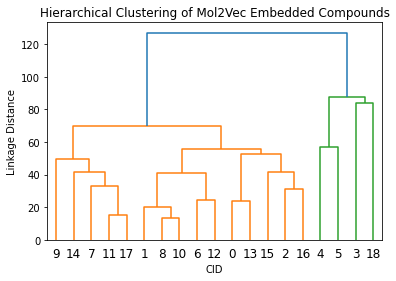

In [1]:
#1 Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from config import BASE_DIR

dataset = pd.read_csv(f'{BASE_DIR}/VECTORIZED_CSV/vectors_list.csv')
X = dataset

#3 Using the dendrogram to find the optimal numbers of clusters. # First thing we're going to do is to import scipy
# library. scipy is #an open source Python library that contains tools to do #hierarchical clustering and building
# dendrograms. Only import the #needed tool. import scipy.cluster.hierarchy as sch #Lets create a dendrogram variable
# linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on
# which data we apply and engage. This is X dataset dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
# plt.title('Dendrogram') plt.xlabel('Compounds') plt.ylabel('Euclidean distances') plt.show()


#4 Fitting hierarchical clustering to the Mall_Customes dataset # There are two algorithms for hierarchical
# clustering: #Agglomerative Hierarchical Clustering and # Divisive Hierarchical Clustering. We choose Euclidean
# distance and ward method for our algorithm class from sklearn.cluster import AgglomerativeClustering hc =
# AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward') # Lets try to fit the hierarchical
# clustering algorithm  to dataset #X while creating the clusters vector that tells for each customer #which cluster
# the customer belongs to. y_hc=hc.fit_predict(X)




from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
     
    #print(linkage_matrix)
    # Plot the corresponding dendrogram ; 120
    dendrogram(linkage_matrix, color_threshold=110, **kwargs)
   
    # setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)
plt.title('Hierarchical Clustering of Mol2Vec Embedded Compounds')
# plot the top three levels of the dendrogram
plot_dendrogram(model)
plt.xlabel("CID")
plt.ylabel("Linkage Distance")
plt.show()
